In [14]:
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, StructType, StructField, StringType
import folium
from folium import plugins
from folium import LinearColormap
import matplotlib.colors as mcolors

In [15]:
######################################
# Initialize Spark session
######################################

spark = SparkSession.builder.appName("GridProcessing").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [16]:
######################################
# Define the grid cell size
######################################

lat_start, lon_start = 45.687757, 4.744455

lat_step = 0.0030  # 500m en latitude
lon_step = 0.0045  # 500m en longitude

rows = 40 # 20km * 500m
cols = 60 # 20km * 500m

# Create a list of all grid cells
grid_cells = []
for i in range(rows):
    for j in range(cols):
        lat1 = lat_start + i * lat_step
        lon1 = lon_start + j * lon_step
        lat2 = lat1 + lat_step
        lon2 = lon1 + lon_step
        lat_center = (lat1 + lat2) / 2
        lon_center = (lon1 + lon2) / 2
        
        grid_cells.append((i * cols + j, lat1, lon1, lat2, lon2, lat_center, lon_center))

# Convert the list to a DataFrame
grid_cells_df = spark.createDataFrame(grid_cells, ["id", "lat1", "lon1", "lat2", "lon2", "lat_center", "lon_center"])

In [17]:
######################################
# Load cleaned datasets
######################################

fonciere_schema = StructType([
    StructField("VALEUR_FONCIERE", FloatType(), False), 
    StructField("CODE_POSTAL", StringType(), False),
    StructField("NOM_COMMUNE", StringType(), False), 
    StructField("TYPE_LOCAL", StringType(), False),
    StructField("SURFACE_REELLE_BATI", FloatType(), False), 
    StructField("SURFACE_TERRAIN", FloatType(), False), 
    StructField("LONGITUDE", FloatType(), False),
    StructField("LATITUDE", FloatType(), False), 
    StructField("prix_du_m_carre", FloatType(), False)
])

hopitaux_schema = StructType([
 StructField("NOM", StringType(), False),
 StructField("LATITUDE", FloatType(), False),
 StructField("LONGITUDE", FloatType(), False)
])

docteurs = StructType([
 StructField("ID", StringType(), False),
 StructField("PROFESSION", StringType(), False),
 StructField("COMMUNE", StringType(), False),
 StructField("NOM", StringType(), False),
 StructField("LATITUDE", FloatType(), False),
 StructField("LONGITUDE", FloatType(), False)
])

stations_schema = StructType([
    StructField("NOM", StringType(), False),
    StructField("LONGITUDE", FloatType(), False),
    StructField("LATITUDE", FloatType(), False),
    StructField("NB", FloatType(), False),
    StructField("A", FloatType(), False),
    StructField("B", FloatType(), False),
    StructField("C", FloatType(), False),
    StructField("D", FloatType(), False),
    StructField("F1", FloatType(), False),
    StructField("F2", FloatType(), False),
])

parking_schema = StructType([
     StructField("NOM", StringType(), False),
     StructField("HANDICAP", StringType(), False), 
     StructField("CAPACITE_TOTALE", StringType(), False), 
     StructField("CAPACITE_PERMANENTE", StringType(), False), 
     StructField("ACCUEIL_TEMPORAIRE", StringType(), False), 
     StructField("LONGITUDE", FloatType(), False),
     StructField("LATITUDE", FloatType(), False)
])

fonciere_df = spark.read.option("header", True).schema(fonciere_schema).csv("./cleaned/valeurs_foncieres.csv")
hopitaux_df = spark.read.option("header", True).option("sep", ";").schema(hopitaux_schema).csv("./cleaned/adr_voie_lieu.adrhopital.csv")
docteurs_df = spark.read.option("header", True).schema(docteurs).csv("./cleaned/pam-doc.csv")
df_stations = spark.read.csv('cleaned/subway_stations_cleaned.csv', schema=stations_schema, header=True, sep=',')
parking_df = spark.read.option("header", True).schema(parking_schema).csv("./cleaned/places_parking.csv")

In [18]:
######################################
# Filter sets according to the zone
######################################

# Zone bottom left and top right corners
zone_bottom_left_lat = lat_start
zone_bottom_left_lon = lon_start
zone_top_right_lat = lat_start + (rows * lat_step)
zone_top_right_lon = lon_start + (cols * lon_step)

# Remove all elements that are not part of the delimited zone

fonciere_df = fonciere_df.filter(
    (fonciere_df.LATITUDE >= zone_bottom_left_lat) & 
    (fonciere_df.LATITUDE <= zone_top_right_lat) & 
    (fonciere_df.LONGITUDE >= zone_bottom_left_lon) & 
    (fonciere_df.LONGITUDE <= zone_top_right_lon)
)

hopitaux_df = hopitaux_df.filter(
    (hopitaux_df.LATITUDE >= zone_bottom_left_lat) & 
    (hopitaux_df.LATITUDE <= zone_top_right_lat) & 
    (hopitaux_df.LONGITUDE >= zone_bottom_left_lon) & 
    (hopitaux_df.LONGITUDE <= zone_top_right_lon)
)

docteurs_df = docteurs_df.filter(
    (docteurs_df.LATITUDE >= zone_bottom_left_lat) & 
    (docteurs_df.LATITUDE <= zone_top_right_lat) & 
    (docteurs_df.LONGITUDE >= zone_bottom_left_lon) & 
    (docteurs_df.LONGITUDE <= zone_top_right_lon)
)

df_stations = df_stations.filter(
    (df_stations.LATITUDE >= zone_bottom_left_lat) & 
    (df_stations.LATITUDE <= zone_top_right_lat) & 
    (df_stations.LONGITUDE >= zone_bottom_left_lon) & 
    (df_stations.LONGITUDE <= zone_top_right_lon)
)

parking_df = parking_df.filter(
    (parking_df.LATITUDE >= zone_bottom_left_lat) & 
    (parking_df.LATITUDE <= zone_top_right_lat) & 
    (parking_df.LONGITUDE >= zone_bottom_left_lon) & 
    (parking_df.LONGITUDE <= zone_top_right_lon)
)

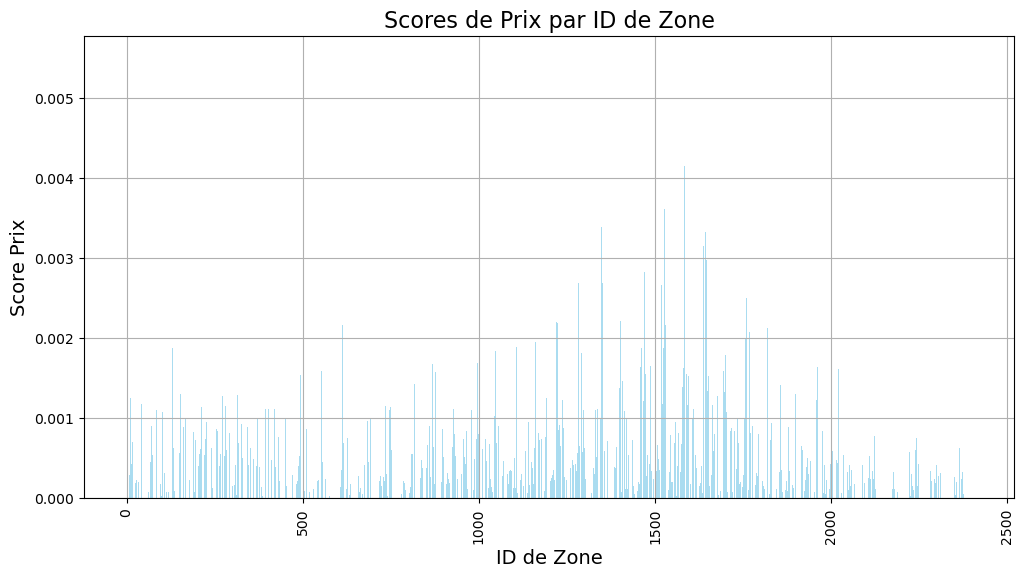

In [19]:
######################################
# Fonciere data
######################################

# Join the grid cells DataFrame with fonciere_df based on latitude and longitude conditions
joined_df = fonciere_df.crossJoin(grid_cells_df).where(
    (fonciere_df.LATITUDE >= grid_cells_df.lat1) & (fonciere_df.LATITUDE <= grid_cells_df.lat2) &
    (fonciere_df.LONGITUDE >= grid_cells_df.lon1) & (fonciere_df.LONGITUDE <= grid_cells_df.lon2)
)

nb_total_ventes_global = fonciere_df.count()
prix_moyen_global_m_carre = fonciere_df.agg(F.mean("prix_du_m_carre")).first()[0]

# Group by grid cell ID and calculate the mean and max values for prix_du_m_carre
fonciere_joined_df = joined_df.groupBy("id").agg(
    F.mean("prix_du_m_carre").alias("mean_prix_du_m_carre"),
    F.count("*").alias("count_nb_ventes"),
).fillna(
    0, subset=["mean_prix_du_m_carre", "count_nb_ventes"]
).withColumn(
    "score_prix",
    F.when((F.col("mean_prix_du_m_carre") == 0) & (F.col("count_nb_ventes") == 0), 0)
    .otherwise((1 / F.col("mean_prix_du_m_carre")) * (F.col("count_nb_ventes") / nb_total_ventes_global))
)

fonciere_joined_df = grid_cells_df.join(fonciere_joined_df, on="id", how="left").orderBy("score_prix")
fonciere_joined_df = fonciere_joined_df.fillna(0)
fonciere_joined_df = fonciere_joined_df.select("id", "score_prix").orderBy(F.col("score_prix").asc())

sum_scores = fonciere_joined_df.select(F.sum("score_prix")).collect()[0][0]
fonciere_joined_df = fonciere_joined_df.withColumn("score_prix_normalized", F.col("score_prix") / F.lit(sum_scores))

# Histogramme

import matplotlib.pyplot as plt

sorted_df = fonciere_joined_df.orderBy("score_prix_normalized")
score_prix_values = sorted_df.select("score_prix_normalized").rdd.flatMap(lambda x: x).collect()
id_values = sorted_df.select("id").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.bar(id_values, score_prix_values, color='skyblue', alpha=0.7)

plt.title("Scores de Prix par ID de Zone", fontsize=16)
plt.xlabel("ID de Zone", fontsize=14)
plt.ylabel("Score Prix", fontsize=14)

plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [20]:
######################################
# Hopitaux data
######################################

# Broadcast is more efficient than a crossJoin
grid_cells_df_broadcast = F.broadcast(grid_cells_df)

hopitaux_joined_df = (
    hopitaux_df
    .join(grid_cells_df_broadcast, 
          (hopitaux_df.LATITUDE >= grid_cells_df_broadcast.lat1) & 
          (hopitaux_df.LATITUDE <= grid_cells_df_broadcast.lat2) &
          (hopitaux_df.LONGITUDE >= grid_cells_df_broadcast.lon1) & 
          (hopitaux_df.LONGITUDE <= grid_cells_df_broadcast.lon2))
    .groupBy("id")
    .count()
    .withColumn("score_hopitaux", (F.col("count") / hopitaux_df.count()))
    .select("id", "score_hopitaux")
    .orderBy(F.col("score_hopitaux").desc())
)

hopitaux_joined_df.show(truncate=False, vertical=True)

-RECORD 0------------------------------
 id             | 1233                 
 score_hopitaux | 0.06666666666666667  
-RECORD 1------------------------------
 id             | 1940                 
 score_hopitaux | 0.044444444444444446 
-RECORD 2------------------------------
 id             | 580                  
 score_hopitaux | 0.044444444444444446 
-RECORD 3------------------------------
 id             | 1113                 
 score_hopitaux | 0.044444444444444446 
-RECORD 4------------------------------
 id             | 1628                 
 score_hopitaux | 0.044444444444444446 
-RECORD 5------------------------------
 id             | 26                   
 score_hopitaux | 0.022222222222222223 
-RECORD 6------------------------------
 id             | 1677                 
 score_hopitaux | 0.022222222222222223 
-RECORD 7------------------------------
 id             | 1211                 
 score_hopitaux | 0.022222222222222223 
-RECORD 8------------------------------


In [21]:
######################################
# PAM data
######################################

# Calculer le nombre de professions distinctes
distinct_profession_count = docteurs_df.select("PROFESSION").distinct().count()

practitiens_final = (
    docteurs_df
    .crossJoin(grid_cells_df_broadcast.withColumnRenamed("id", "zone_id"))
    .where(
        (F.col("LATITUDE") >= F.col("lat1")) & (F.col("LATITUDE") <=F.col("lat2")) &
        (F.col("LONGITUDE") >= F.col("lon1")) & (F.col("LONGITUDE") <= F.col("lon2"))
    )
    # Calculer le ratio de praticiens par profession
    .groupBy("zone_id", "PROFESSION")
    .agg(F.count("*").alias("filtered_count"))
    # totaux par profession
    .join(
        docteurs_df.groupBy("PROFESSION").agg(F.count("*").alias("profession_count")),
        on="PROFESSION",
        how="left"
    )
    # joindre le ratio de praticiens par profession et les totaux par profession
    .withColumn(
        "ratio",
        F.when(F.col("profession_count") > 0, F.col("filtered_count") / F.col("profession_count")).otherwise(0)
    )
    .groupBy("zone_id")
    .agg(F.sum("ratio").alias("sum_ratios"))
    # nombre de profession / zone
    .withColumn(
        "score_practicien",
        F.when(F.col("sum_ratios").isNull(), F.lit(0))
        .otherwise(F.col("sum_ratios") / F.lit(distinct_profession_count))
    )
    .join(grid_cells_df_broadcast, grid_cells_df_broadcast.id == F.col("zone_id"), how="left")
    .drop("sum_ratios", "id")
    .orderBy(F.col("score_practicien").desc())
    .select(
        "zone_id", "score_practicien"
    )
    .fillna(0, subset=["score_practicien"])
)


practitiens_final.show(truncate=False, vertical=True)

-RECORD 0--------------------------------
 zone_id          | 1990                 
 score_practicien | 0.07994466299447968  
-RECORD 1--------------------------------
 zone_id          | 929                  
 score_practicien | 0.07510748307838261  
-RECORD 2--------------------------------
 zone_id          | 1989                 
 score_practicien | 0.06827409252148196  
-RECORD 3--------------------------------
 zone_id          | 1050                 
 score_practicien | 0.06310114065447067  
-RECORD 4--------------------------------
 zone_id          | 1211                 
 score_practicien | 0.059633400369105756 
-RECORD 5--------------------------------
 zone_id          | 1645                 
 score_practicien | 0.03460472167779309  
-RECORD 6--------------------------------
 zone_id          | 1705                 
 score_practicien | 0.03185790930498466  
-RECORD 7--------------------------------
 zone_id          | 1460                 
 score_practicien | 0.029546147863

In [22]:
######################################
# Subway stations data
######################################

# Calculer le total global des arrêts par ligne
total_arrets_par_ligne = df_stations.select(
    F.sum("A").alias("total_A"),
    F.sum("B").alias("total_B"),
    F.sum("C").alias("total_C"),
    F.sum("D").alias("total_D"),
    F.sum("F1").alias("total_F1"),
    F.sum("F2").alias("total_F2")
).collect()[0]

# Diffuser la grille pour optimiser la jointure
grid_cells_df_broadcast = F.broadcast(grid_cells_df)

# Assigner les stations de métro aux cases de la grille
stations_to_grid = (
    df_stations
    .crossJoin(grid_cells_df_broadcast.withColumnRenamed("id", "zone_id"))
    .where(
        (F.col("latitude") >= F.col("lat1")) & (F.col("latitude") <= F.col("lat2")) &
        (F.col("longitude") >= F.col("lon1")) & (F.col("longitude") <= F.col("lon2"))
    )
)

# Calculer le ratio pour chaque ligne
for ligne in ["A", "B", "C", "D", "F1", "F2"]:
    total_arrets = total_arrets_par_ligne[f"total_{ligne}"]
    stations_to_grid = stations_to_grid.withColumn(
        f"ratio_{ligne}",
        F.when(F.col(ligne) > 0, F.col(ligne) / total_arrets).otherwise(0)
    )

# Agréger les scores pour chaque case de la grille
stations_to_grid = (
    stations_to_grid
    .groupBy("zone_id")
    .agg(
        *(F.sum(f"ratio_{ligne}").alias(f"sum_ratio_{ligne}") for ligne in ["A", "B", "C", "D", "F1", "F2"])
    )
)

# Calculer le score final pour chaque case de la grille
stations_score = stations_to_grid.withColumn(
    "score_metro",
    sum(F.col(f"sum_ratio_{ligne}") for ligne in ["A", "B", "C", "D", "F1", "F2"]) / len(["A", "B", "C", "D", "F1", "F2"])
)


# Sélectionner uniquement l'id et le score_metro
stations_score_final = stations_score.select(
    F.col("zone_id").alias("id"),
    F.col("score_metro")
).fillna(0)

# Afficher le résultat final
stations_score_final.show(truncate=False, vertical=True)

-RECORD 0---------------------------
 id          | 1642                 
 score_metro | 0.011904761904761904 
-RECORD 1---------------------------
 id          | 1594                 
 score_metro | 0.011904761904761904 
-RECORD 2---------------------------
 id          | 1640                 
 score_metro | 0.03333333333333333  
-RECORD 3---------------------------
 id          | 1458                 
 score_metro | 0.15                 
-RECORD 4---------------------------
 id          | 555                  
 score_metro | 0.013888888888888888 
-RECORD 5---------------------------
 id          | 1051                 
 score_metro | 0.011111111111111112 
-RECORD 6---------------------------
 id          | 1650                 
 score_metro | 0.011904761904761904 
-RECORD 7---------------------------
 id          | 1282                 
 score_metro | 0.024999999999999998 
-RECORD 8---------------------------
 id          | 1592                 
 score_metro | 0.011904761904761904 
-

In [23]:
######################################
# Parking data
######################################

# Get the total parking capacity
total_parking_capacity = parking_df.select(F.sum(parking_df.CAPACITE_TOTALE.cast('int')).alias('total_capacity')).collect()[0]['total_capacity']

parking_final_df = (
    parking_df.join(grid_cells_df, (
        (parking_df.LATITUDE >= grid_cells_df.lat1) & 
        (parking_df.LATITUDE <= grid_cells_df.lat2) &
        (parking_df.LONGITUDE >= grid_cells_df.lon1) & 
        (parking_df.LONGITUDE <= grid_cells_df.lon2)
    ), how="right")
    .groupBy("id")
    .agg(
        F.sum(parking_df.CAPACITE_TOTALE.cast('int')).alias('total_capacity_per_zone')
    )
    .withColumn(
        "score_parking",
        F.when(F.col("total_capacity_per_zone").isNotNull(), F.col("total_capacity_per_zone") / total_parking_capacity)
        .otherwise(0)
    )
    .select(
        "id", "score_parking"
    )
    .fillna(0, subset=["score_parking"])
    .orderBy(F.col("score_parking").desc()) 
)

parking_final_df.show(truncate=False, vertical=True)

-RECORD 0-----------------------------
 id            | 1343                 
 score_parking | 0.06351931330472103  
-RECORD 1-----------------------------
 id            | 1880                 
 score_parking | 0.05436337625178827  
-RECORD 2-----------------------------
 id            | 1813                 
 score_parking | 0.044349070100143065 
-RECORD 3-----------------------------
 id            | 927                  
 score_parking | 0.03805436337625179  
-RECORD 4-----------------------------
 id            | 1338                 
 score_parking | 0.03662374821173105  
-RECORD 5-----------------------------
 id            | 2119                 
 score_parking | 0.0351931330472103   
-RECORD 6-----------------------------
 id            | 1642                 
 score_parking | 0.03118741058655222  
-RECORD 7-----------------------------
 id            | 692                  
 score_parking | 0.030901287553648068 
-RECORD 8-----------------------------
 id            | 2165    

In [24]:
######################################
# Assembling individal scores
######################################

# important de partir de fonciere_joined_df pour ne pas perdre les cellules sans hopitaux
final_df = grid_cells_df.join(fonciere_joined_df, on="id", how="left")
final_df = final_df.join(hopitaux_joined_df, on="id", how="left")
final_df = final_df.join(practitiens_final, final_df.id == practitiens_final.zone_id, how="left").drop("zone_id")
final_df = final_df.join(stations_score_final, on="id", how="left").fillna(0)
final_df = final_df.join(parking_final_df, on="id", how="left")

final_df = final_df.fillna(0)

assert final_df.count() == grid_cells_df.count(), "Both datasets must contains the same number of items"

In [31]:
######################################
# Score smoothing
######################################

grid_final_df = final_df.withColumn("row", F.floor(F.col("id") / cols))
grid_final_df = grid_final_df.withColumn("col", F.col("id") % cols)

# Jointure pour trouver les voisins
grid_with_neighbors = grid_final_df.alias("center").join(
    grid_final_df.alias("neighbor"),
    (F.abs(F.col("center.row") - F.col("neighbor.row")) <= 1) & 
    (F.abs(F.col("center.col") - F.col("neighbor.col")) <= 1),
    how="inner"
)

# Agréger les valeurs des voisins (moyenne simple dans ce cas)
smoothed_grid = grid_with_neighbors.groupBy("center.id").agg(
    F.mean(F.col("neighbor.score_prix_normalized")).alias("smoothed_score_prix"),
    F.mean(F.col("neighbor.score_hopitaux")).alias("smoothed_score_hopitaux"),
    F.mean(F.col("neighbor.score_metro")).alias("smoothed_score_metro"),
    F.mean(F.col("neighbor.score_practicien")).alias("smoothed_score_practicien"),
    F.mean(F.col("neighbor.score_parking")).alias("smoothed_score_parking")
)

# Joindre les scores lissés avec le DataFrame final
final_df_smoothed = final_df.join(smoothed_grid, on="id", how="left")

weights = {
    "score_prix": 60,
    "score_hopitaux": 30,
    "score_practicien": 16,
    "score_metro": 20,
    "score_parking": 10
}

final_df_smoothed = final_df_smoothed.withColumn(
    "smoothed_score_final",
    (F.col("smoothed_score_prix") * weights["score_prix"] + 
     F.col("smoothed_score_hopitaux") * weights["score_hopitaux"] + 
     F.col("smoothed_score_practicien") * weights["score_practicien"] + 
     F.col("smoothed_score_metro") * weights["score_metro"] + 
     F.col("smoothed_score_parking") * weights["score_parking"])
    / 15
)

final_df_smoothed = final_df_smoothed.filter(final_df_smoothed.smoothed_score_final > 0.0001)

final_df_smoothed.orderBy(F.col("smoothed_score_final").desc()).show(truncate=False, vertical=True)

final_df_smoothed.show(truncate=False, vertical=True)

final_df_smoothed_pandas = final_df_smoothed.toPandas()
final_df_smoothed_pandas.to_csv('grid_data.csv', index=False)

-RECORD 0------------------------------------------
 id                        | 1398                  
 lat1                      | 45.756757             
 lon1                      | 4.825455000000001     
 lat2                      | 45.759757             
 lon2                      | 4.829955000000001     
 lat_center                | 45.758257             
 lon_center                | 4.827705000000001     
 score_prix                | 3.4357422318444144E-7 
 score_prix_normalized     | 0.0017801937651155592 
 score_hopitaux            | 0.0                   
 score_practicien          | 0.015675287162719664  
 score_metro               | 0.0                   
 score_parking             | 0.0                   
 smoothed_score_prix       | 0.0013915974443529855 
 smoothed_score_hopitaux   | 0.0                   
 smoothed_score_metro      | 0.034656084656084656  
 smoothed_score_practicien | 0.0051151208043467965 
 smoothed_score_parking    | 0.004705134318868225  
 smoothed_sc

In [32]:
lat, lon = 45.751719, 4.880243
zoom_start = 12

token = 'R806l54GTKL9S0hBAWDCwZuJNOf6hVBI0tIPPXGepaGkGe9eOztj7JyWvGDiiwot'

tiles = 'https://tile.jawg.io/jawg-lagoon/{z}/{x}/{y}{r}.png?access-token=' + token
attr = (
    '&copy; <a href="https://jawg.io" title="Tiles Courtesy of Jawg Maps" target="_blank">Jawg Maps</a> &copy; '
    '<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
)

m = folium.Map(location=[lat, lon], tiles=tiles, attr=attr, zoom_start=zoom_start)

quantiles = pd.qcut(final_df_smoothed_pandas['smoothed_score_final'], q=10, labels=False, retbins=True, duplicates='drop')[1]
quantiles_sorted = sorted(quantiles)
num_colors = len(quantiles_sorted)

def interpolate_color(start_color, middle_color, end_color, num_steps):
    start_rgb = np.array(mcolors.hex2color(start_color))
    middle_rgb = np.array(mcolors.hex2color(middle_color))
    end_rgb = np.array(mcolors.hex2color(end_color))

    middle_step = num_steps // 2
    end_step = num_steps - middle_step

    first_half = [
        mcolors.rgb2hex(start_rgb + (middle_rgb - start_rgb) * i / middle_step) for i in range(middle_step)
    ]
    
    second_half = [
        mcolors.rgb2hex(middle_rgb + (end_rgb - middle_rgb) * i / end_step) for i in range(end_step)
    ]

    return first_half + second_half

colors = interpolate_color('#00FF00', '#FFFF00', '#FF0000', num_colors)

colormap = LinearColormap(
    colors=colors,
    index=quantiles_sorted,
    vmin=quantiles_sorted[0],
    vmax=quantiles_sorted[-1],
)

def get_color(value):
    if value == 0:
        return '#FFFFFF'
    else:
        return colormap(value)

for index, row in final_df_smoothed_pandas.iterrows():
    lat1, lon1, lat2, lon2 = row['lat1'], row['lon1'], row['lat2'], row['lon2']
    
    square_coords = [(lat1, lon1), (lat1, lon2), (lat2, lon2), (lat2, lon1)]

    s_prix = (row['smoothed_score_prix'])
    s_hopitaux = (row['smoothed_score_hopitaux'])
    s_pam = (row['smoothed_score_practicien'])
    s_metro = (row['smoothed_score_metro'])
    s_parking = (row['smoothed_score_parking'])
    s_final = (row['smoothed_score_final'])
    
    color = get_color(s_final)
    
    tooltip_text = f"""
    Score détaillé de la zone :<br><br>
    - Prix: {s_prix * 100:.5f}<br>
    - Hopitaux: {s_hopitaux * 100:.5f}<br>
    - Praticiens: {s_pam * 100:.5f}<br>
    - Metro: {s_metro * 100:.5f}<br>
    - Parking: {s_parking * 100:.5f}<br><br>
    
    Score final: {s_final:.8f}
    """

    folium.Polygon(
        locations=square_coords,
        color=None,
        fill=True,
        fill_color=color,
        fill_opacity=0.5,
        popup=folium.Popup(tooltip_text, max_width=200)
    ).add_to(m)
    
colormap.caption = "Echelle"
colormap.add_to(m)

m